Hunter Bennett | Glass Lab | Kupffer Strains | 08 Feb 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

Set working directory

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/'
workingDirectory = '/home/h1bennet/strains/results/04_Strains_AMLNtoControl/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Copy over merged ATAC-seq peaks from ATAC-seq analysis.

First we will need a shared ATAC-peak file with peaks for control and amln diet across all strains

In [3]:
%%bash
# if directories don't exist, create them
if [ ! -d ./merged_peaks/ ]; then mkdir ./merged_peaks; fi

cp /gpfs/data01/glasslab/home/h1bennet/strains/results/00_Strains_Control_ATAC/merged_peaks/idr_peaks_merged.txt \
./merged_peaks/control_idr_peaks_merged.txt

cp /gpfs/data01/glasslab/home/h1bennet/strains/results/01_Strains_AMLN_ATAC/merged_peaks/idr_peaks_merged.txt \
./merged_peaks/amln_idr_peaks_merged.txt

mergePeaks ./merged_peaks/control_idr_peaks_merged.txt \
./merged_peaks/amln_idr_peaks_merged.txt > ./merged_peaks/amln_control_idr_atac_peaks_merged.txt

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./merged_peaks/control_idr_peaks_merged.txt (64770 total) and ./merged_peaks/control_idr_peaks_merged.txt (64770 total)
	Comparing ./merged_peaks/control_idr_peaks_merged.txt (64770 total) and ./merged_peaks/amln_idr_peaks_merged.txt (61711 total)
	Comparing ./merged_peaks/amln_idr_peaks_merged.txt (61711 total) and ./merged_peaks/control_idr_peaks_merged.txt (64770 total)
	Comparing ./merged_peaks/amln_idr_peaks_merged.txt (61711 total) and ./merged_peaks/amln_idr_peaks_merged.txt (61711 total)

./merged_peaks/control_idr_peaks_merged.txt	./merged_peaks/amln_idr_peaks_merged.txt	Total	Name
	X	11213	./merged_peaks/amln_idr_peaks_merged.txt
X		14578	./merged_peaks/control_idr_peaks_merged.txt
X	X	49259	./merged_peaks/control_idr_peaks_merged.txt|./merged_peaks/amln_idr_peaks_merged.txt


### Next: Annotate peaks

from looking on the browser Balb1A and NCoR 1A look too clonal for further analysis

In [4]:
# drop_files = ['NaN']

drop_files = ['02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15A_180423']

In [5]:
# grab relevant tag directories
control = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/*Kupffer*H3K27Ac*'))
amln = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/*Kupffer*H3K27Ac*')) 
# concatenate into single array
tagdirs = np.concatenate((control, amln))

tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [6]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl',
                    './merged_peaks/amln_control_idr_atac_peaks_merged.txt',
                    'mm10', '-size 1000', '-raw', '-d \\\n',
                    ' \\\n'.join(tagdirs), '>',
                    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl',
                     './merged_peaks/amln_control_idr_atac_peaks_merged.txt',
                    'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                    ' \\\n'.join(tagdirs), '>',
                    './merged_peaks/ann_norm_amln_control_idr_atac_peaks_merged.txt &\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Summary plots

In [7]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [8]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_amln_control_idr_atac_peaks_merged.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks prior to making summary plots

In [9]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1], [2,3], [4,5], [6,7], [8,9], [10,11]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

73615 total peaks
filtering low tag count peaks
67752 total peaks


### Mean variance plot

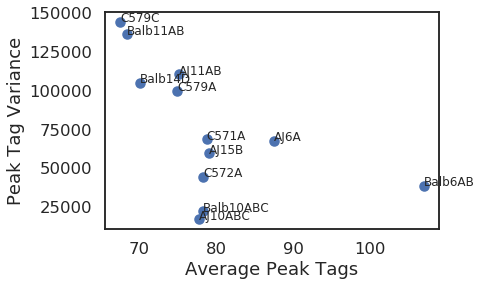

In [10]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

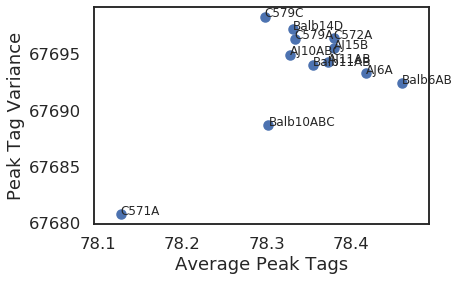

In [11]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Correlation heatmap

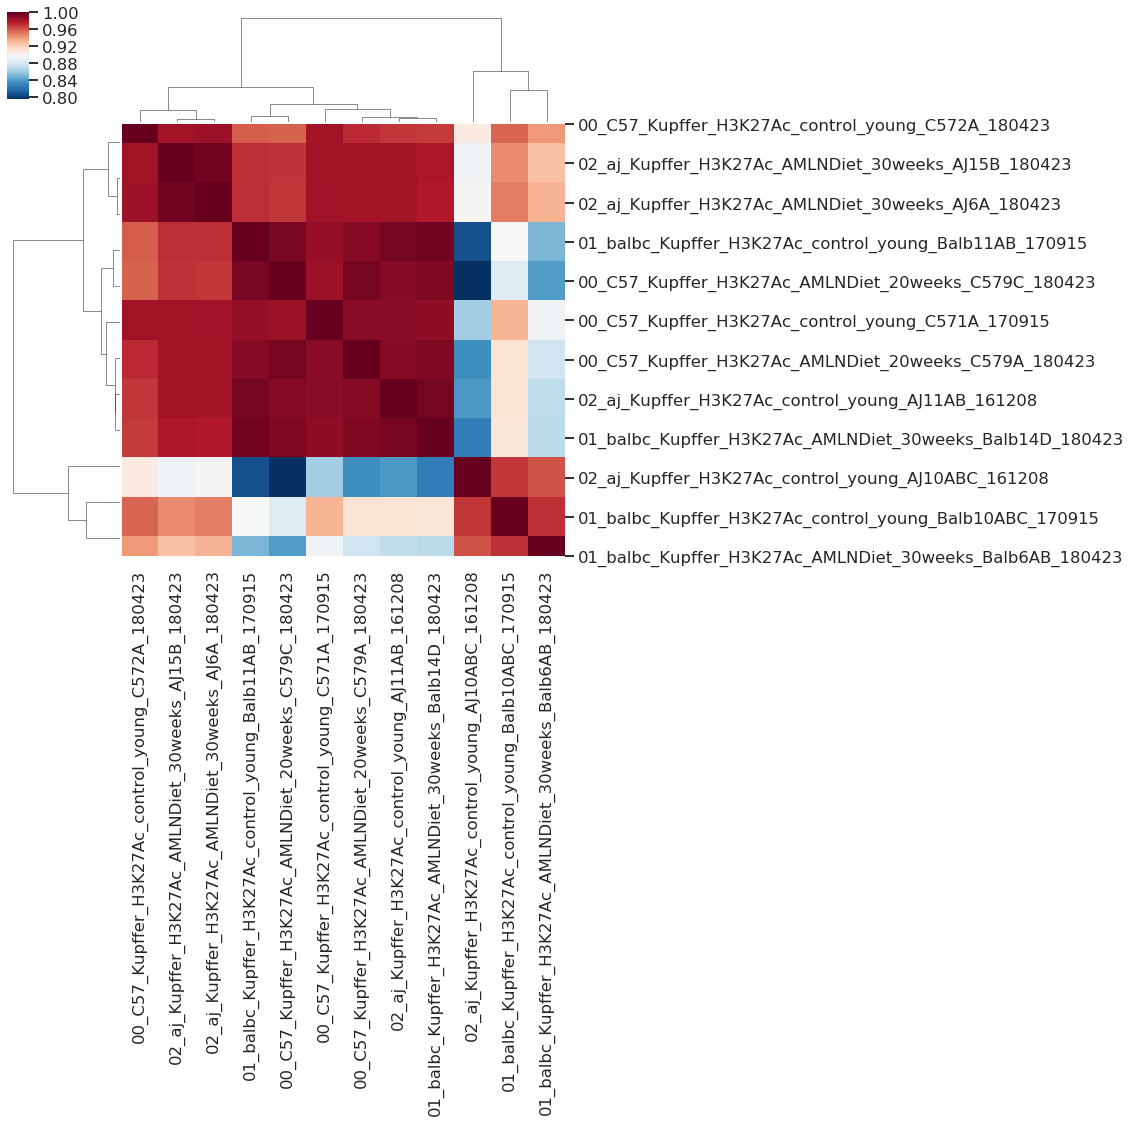

In [12]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

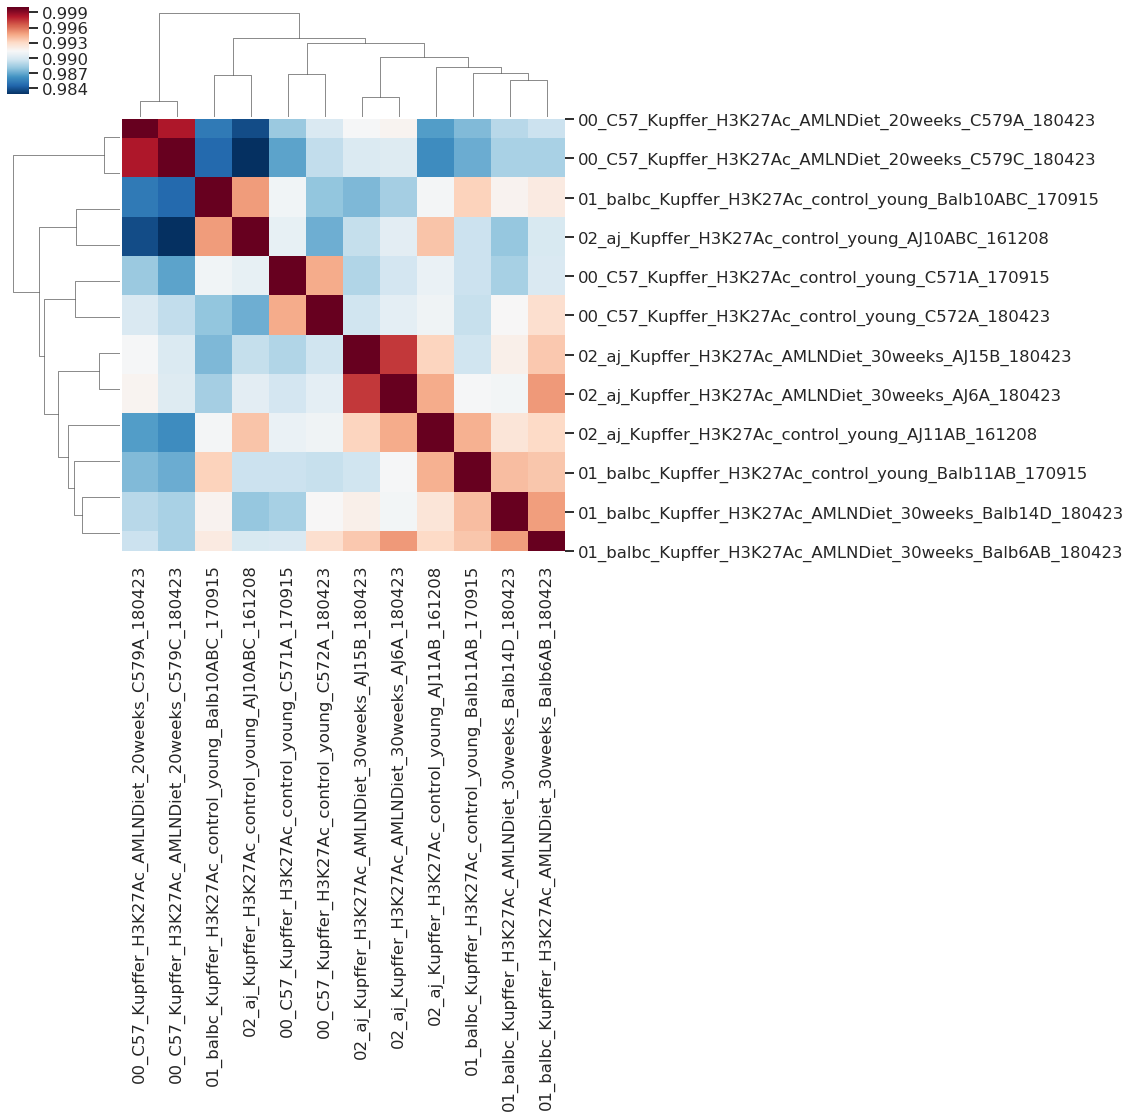

In [13]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

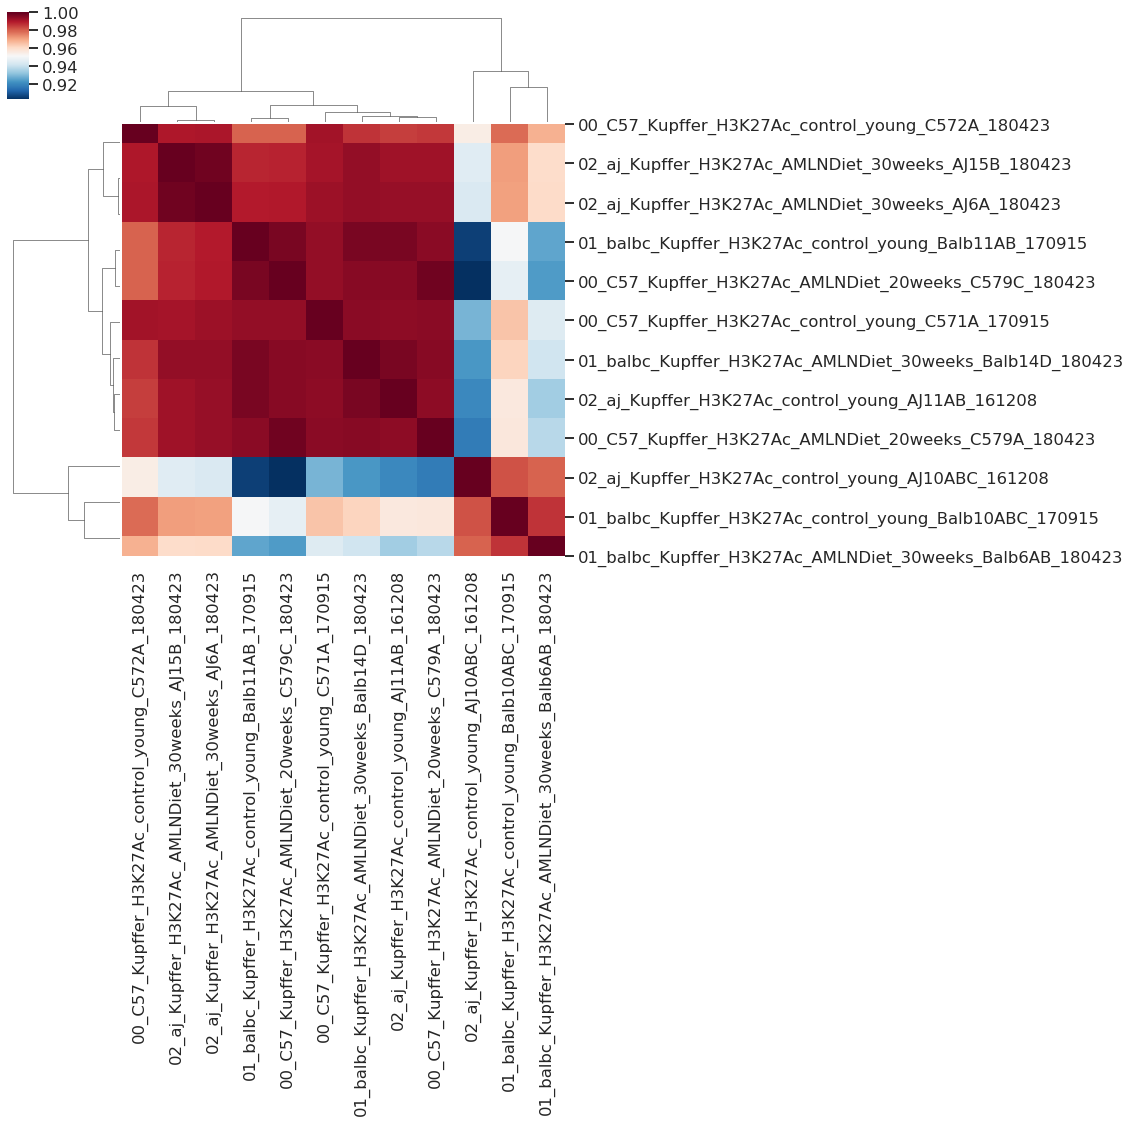

In [14]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [15]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[6]
sampledate = samples.str.split('_').str[7]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

In [16]:
samplesDF

,mouse,group,strain,celltype,treatment,treatment_time,mouse_id,sample_date
0,00_C57_Kupffer_H3K27Ac_control_young_C571A_170915,00,C57,Kupffer,control,young,C571A,170915
1,00_C57_Kupffer_H3K27Ac_control_young_C572A_180423,00,C57,Kupffer,control,young,C572A,180423
2,01_balbc_Kupffer_H3K27Ac_control_young_Balb10A...,01,balbc,Kupffer,control,young,Balb10ABC,170915
3,01_balbc_Kupffer_H3K27Ac_control_young_Balb11A...,01,balbc,Kupffer,control,young,Balb11AB,170915
4,02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_16...,02,aj,Kupffer,control,young,AJ10ABC,161208
5,02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208,02,aj,Kupffer,control,young,AJ11AB,161208
6,00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_...,00,C57,Kupffer,AMLNDiet,20weeks,C579A,180423
7,00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_...,00,C57,Kupffer,AMLNDiet,20weeks,C579C,180423
8,01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb...,01,balbc,Kupffer,AMLNDiet,30weeks,Balb14D,180423
9,01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb...,01,balbc,Kupffer,AMLNDiet,30weeks,Balb6AB,180423


### Look at PCA plots for all the samples

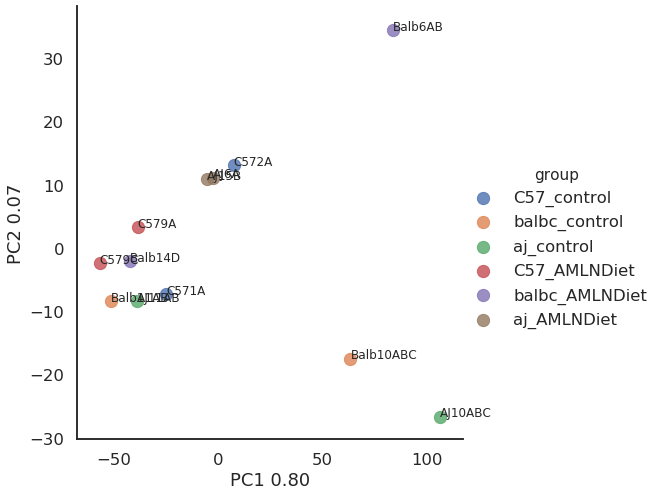

In [17]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

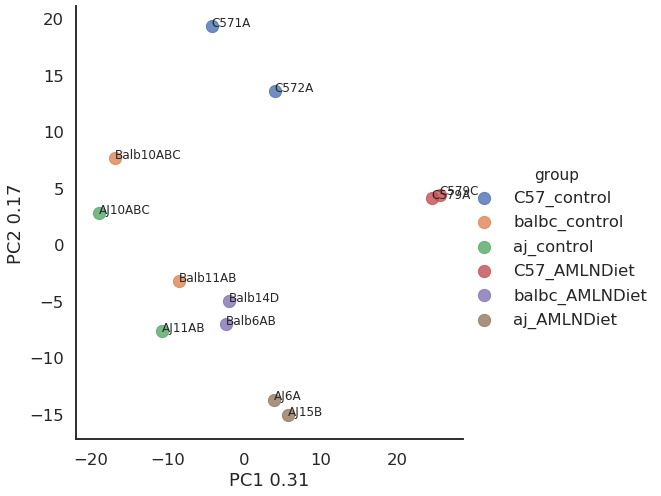

In [18]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2_quantnorm.png', bbox_inches='tight')

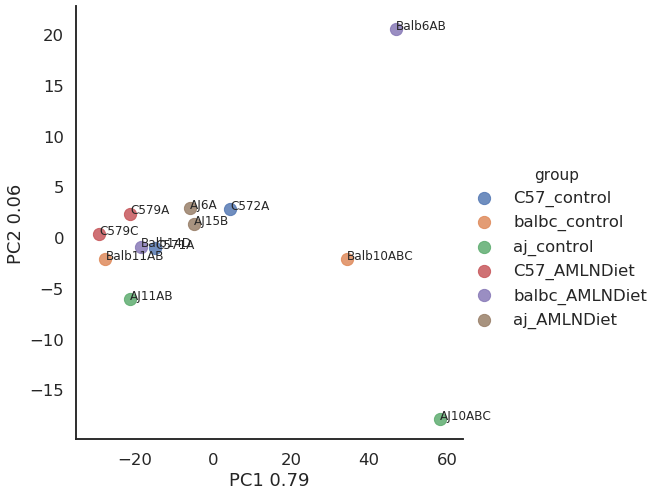

In [19]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_pca1_pca2.png', bbox_inches='tight')

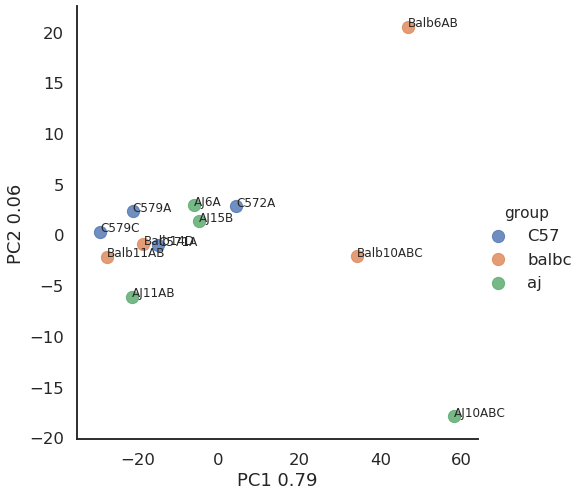

In [20]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.strain,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_strain_pca1_pca2.png', bbox_inches='tight')

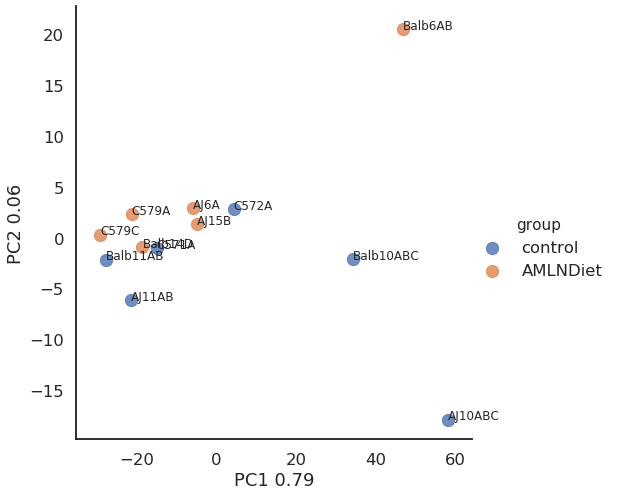

In [21]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_strain_pca1_pca2.png', bbox_inches='tight')

# Make MultiWigHub with Control and amln combined so that peaks are on the same axis

In [ ]:
makeMultiWigHub.pl hrb_strains_viz_h3k27ac_merged_control_vs_amln_30weeks mm10 \
-color 161,217,155 49,163,84 158,202,225 49,130,189 252,146,114 222,45,38 \
-force -d \
/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/merged_tagdirs/00_C57_Kupffer_h3k27ac_young_control/ \
/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/merged_tagdirs/00_C57_Kupffer_AMLN_30weeks_H3K27Ac/ \
/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/merged_tagdirs/01_balbc_Kupffer_h3k27ac_young_control/ \
/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/merged_tagdirs/01_balbc_Kupffer_AMLN_30weeks_H3K27Ac/ \
/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/merged_tagdirs/02_aj_Kupffer_h3k27ac_young_control/ \
/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/merged_tagdirs/02_aj_Kupffer_AMLN_30weeks_H3K27Ac/